<a href="https://colab.research.google.com/github/cesarq88/Imagenes-saltelitales-Landsat-/blob/main/Imagenes_satelitales_landsat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



*   



#Procesamiento de imágenes satelitales  con Python 2022.
Procedemos a importar algunas de la librerias y funciones  que usaremos. 



In [ ]:
%matplotlib inline
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage
from scipy import interpolate
#from scipy.ndimage.filters import uniform_filter
#from scipy.ndimage.measurements import variance
from scipy import signal
import math

from PIL import Image
# La siguiente línea configura al paquete Image para que pueda cargar imágenes
# muy grandes sin errores
Image.MAX_IMAGE_PIXELS = None
# Paquete para invocar al garbage collector
import gc
import os

# Función de realce lineal al p porciento
def realce(vec, p=2):
  aux = np.sort(vec.flatten())
  imin = int(len(aux) * p / 100)
  imax = int(len(aux) * (100 - p) / 100)
  vmin = float(aux[imin])
  vmax = float(aux[imax])
  rimag = (vec - vmin) / (vmax - vmin)
  rimag[rimag < 0] = 0
  rimag[rimag > 1] = 1
  return rimag

# Función para calcular el PCA de una imagen de entrada
def pca(X):
    '''
    Obtiene la descomposición PCA de una imagen de entrada.
    
    Parámetros
    ----------
    X : numpy.array
        Imagen de entrada cuyas dimensiones son [filas, columnas, bandas].
    
    Retornos
    --------
    x_pca : numpy.array
        Array con las componentes principales cuyas dimensiones
        son [filas*columnas, bandas].
    eigen_vals : numpy.array
        Array con los eigen values. 
    eigen_vecs : numpy.array
        Array con los eigen vectors.
    '''
    # Obtenemos las dimensiones
    filas, columnas, bandas = X.shape
    # Reacomodamos la matriz a 2 dimensiones
    xr = np.reshape(X, [filas * columnas, bandas])
    # Centro los datos
    xr = xr - xr.mean(axis=0)
    # Calculamos la matriz de covarianza
    C = np.dot(xr.T, xr) / (filas * columnas - 1)
    # Realizamos la descomposición
    eigen_vals, eigen_vecs = np.linalg.eig(C)
    X_pca = np.dot(xr, eigen_vecs)
    return X_pca, eigen_vals, eigen_vecs


def muestreo(x, y, z, esc=1, kind='cubic'):
    '''
    Realiza un submuestreo o sobremuestreo según el parámetro 
    de entrada esc.
    
    Parámetros
    ----------
    x : numpy.array
        Array de coordenadas en x.
    y : numpy.array
        Array de coordenadas en y.
    z : numpy.array
        Array correspondiente a la imagen que se quiere sub
        o sobre muestrear.
    esc : int
        Indica si se submuestrea o sobremuestrea. Por ejemplo,
        esc=2 realiza un sobremuestreo al doble de tamaño. esc=0.5
        realiza un submuestreo a la mitad.
    kind : str
        Tipo de interpolación utilizada. Ver opciones en scipy.interpolate.interp2d().
        
    Retornos
    --------
    xnew : numpy.array
        Array de nuevas coordenadas en x.
    ynew : numpy.array
        Array de nuevas coordenadas en y.
    f(xnew, ynew) : numpy.array
        Array que contiene la nueva imagen sub o sobre muestreada.
    '''
    f = interpolate.interp2d(x, y, z, kind='cubic')
    xnew = np.arange(x[0], x[-1]+1, (x[1]-x[0])/esc) # válido sólo para escala 2:1
    ynew = np.arange(y[0], y[-1]+1, (y[1]-y[0])/esc) # válido sólo para escala 2:1
    return xnew, ynew, f(xnew, ynew)

def getCalibratedData(imageName, mtlFile):
    '''
    Levanta una imagen de Landsat 8 y el archivo de metadatos,
    devuelve una imagen calibrada a reflectancia.

    Parámetros
    ----------
    imageName : str
        Ruta y nombre de la imagen TIF a levantar.
    mtlFile : str
        Ruta y nombre del archivo de metadatos.

    Retornos
    --------
    img_ref : numpy.array
      Imagen calibrada a reflectancia
    '''
        
    # Del nombre de la imagen extraemos el número de banda
    bandNumber = imageName.split('_')[1].split('.TIF')[0].split('B')[1]
    # Leemos el archivo de metadatos
    with open(mtlFile, 'r') as f:
        metadata = f.readlines()
    # Extraemos los parámetros de calibración
    for line in metadata:
        # Extraemos el factor de multiplicación
        if line.find('REFLECTANCE_MULT_BAND_' + bandNumber) >= 0:
            REFLECTANCE_MULT_BAND = float(line.split('=')[1])
        # Extraemos el factor aditivo
        if line.find('REFLECTANCE_ADD_BAND_' + bandNumber) >= 0:
            REFLECTANCE_ADD_BAND = float(line.split('=')[1])
        # Extraemos el ángulo de elevación solar
        if line.find('SUN_ELEVATION') >= 0:
            SUN_ELEVATION = float(line.split('=')[1])
    # Leemos la imagen
    img = plt.imread(imageName)
    # Calibramos a reflectancia
    img_ref = (REFLECTANCE_MULT_BAND * img + REFLECTANCE_ADD_BAND) / np.sin(SUN_ELEVATION * np.pi/180)
    return img_ref

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir_imag = "/content/drive/MyDrive/LC08229082202109131/" 
os.listdir(dir_imag) #Este comando lista el contenido del directorio

mtlFile = dir_imag + 'LC08229082202109131_MTL.txt'

In [ ]:
# Inspeccionar el archivo LC08_L1TP_229082_20210913_20210924_01_T1_MTL.txt y buscar las líneas llamadas
# REFLECTIVE_LINES y REFLECTIVE_SAMPLES, las cuales contienen el número de filas
# y columnas de las bandas 1 a 7
#REFLECTIVE_LINES = 7751
#REFLECTIVE_SAMPLES = 7691

rlines = 7751
rsamples = 7691
nband=7
 
# Se inicializa una matriz que contendrá las imágenes leídas desde los archivos TIF
l8bands = np.zeros((rlines, rsamples,nband))

# Se realiza la lectura de las imágenes
for i in range(nband):
    print('Cargando banda %d'%(i+1))
    l8bands[:, :, i] = getCalibratedData(dir_imag + 'LC08229082202109131_B' + str(i+1) + '.TIF', mtlFile)

Cargando banda 1
Cargando banda 2
Cargando banda 3
Cargando banda 4
Cargando banda 5
Cargando banda 6
Cargando banda 7


Hacemos un recorte ,nos enfocamos en la parte sur de Cordoba . 

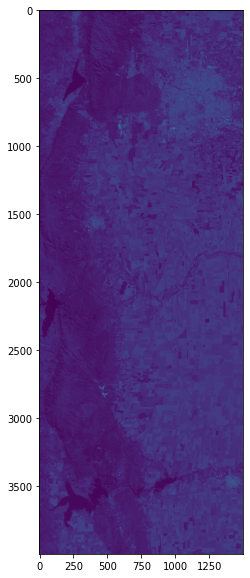

In [ ]:
fini = 2000
finf = 6000
cini = 2500
cfin = 4000
plt.figure(figsize=(10, 10))
plt.imshow(l8bands[fini:finf, cini:cfin, 2]/l8bands[..., [3, 2, 1]].flatten().max())

In [ ]:
l8bands_rec = l8bands[fini:finf, cini:cfin, :]#Definimos el

# Borramos el arreglo que contiene las imágenes sin recortar
del l8bands
# Invocamos al Garbage Collector para asegurarnos que la memoria haya sido liberada
gc.collect()

99

In [ ]:
l8 = np.zeros_like(l8bands_rec)
for i in range(nband):
  l8[:, :, i] = realce(l8bands_rec[:, :, i], 2)

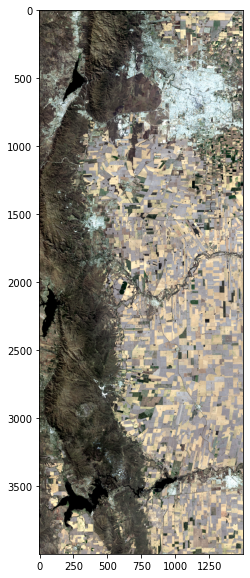

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(l8[:, :, [3, 2, 1]])
imagen_completa_realzada=l8[:,:,[3,2,1]]

In [ ]:
lista= [rec_034, rec_345, rec_023, rec_035]
recorte=img0[fil_inicial: fil_inicial + filas, col_inicial: col_inicial + columnas]

for i in [0,1,2,3,4,5]:
      fre_ia, fre_ib= np.histogram(recorte[:,:,i], bins =256)
      
      plt.plot(fre_ib[:-1], fre_ia )
      plt.show()
   
   

NameError: ignored